In [ ]:
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/text_pre_processing.csv')
df.head(5)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Unnamed: 0.1,title,text,subject,date,label,caps_in_title,text_tokens,text_urls,clean_text,title_urls,twitter_handles,clean_title,clean_text_tokens,clean_title_tokens
0,0,0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,fake,11,"['Donald', 'Trump', 'just', 'couldn', 't', 'wi...",['pic.twitter.com/4FPAe2KypA'],donald trump just couldn t wish all americans ...,[],"['@realDonaldTrump', '@TalbertSwan', '@calvins...",donald trump sends out embarrassing new year’s...,"['donald', 'trump', 'just', 'couldn', 'wish', ...","['donald', 'trump', 'sends', 'out', 'embarrass..."
1,1,1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,fake,8,"['House', 'Intelligence', 'Committee', 'Chairm...",[],house intelligence committee chairman devin nu...,[],[],drunk bragging trump staffer started russian c...,"['house', 'intelligence', 'committee', 'chairm...","['drunk', 'bragging', 'trump', 'staffer', 'sta..."
2,2,2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,fake,15,"['On', 'Friday', 'it', 'was', 'revealed', 'tha...","['pic.twitter.com/XtZW5PdU2b', 'pic.twitter.co...","on friday, it was revealed that former milwauk...",[],"['@SheriffClarke', '@SheriffClarke', '@KeithLe...",sheriff david clarke becomes an internet joke ...,"['on', 'it', 'was', 'revealed', 'that', 'forme...","['sheriff', 'david', 'clarke', 'becomes', 'an'..."
3,3,3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,fake,19,"['On', 'Christmas', 'day', 'Donald', 'Trump', ...","['https://t.co/Fg7VacxRtJ', 'pic.twitter.com/5...","on christmas day, donald trump announced that ...",[],"['@pbump', '@_cingraham', '@_cingraham', '@_ci...",trump is so obsessed he even has obama’s name ...,"['on', 'christmas', 'day', 'donald', 'trump', ...","['trump', 'is', 'so', 'obsessed', 'he', 'even'..."
4,4,4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,fake,11,"['Pope', 'Francis', 'used', 'his', 'annual', '...",[],pope francis used his annual christmas day mes...,[],[],pope francis just called out donald trump duri...,"['pope', 'francis', 'used', 'his', 'annual', '...","['pope', 'francis', 'just', 'called', 'out', '..."


In [ ]:
df = df.drop(['Unnamed: 0'], axis = 1)
df = df.drop(['Unnamed: 0.1'], axis = 1)
df = df.drop(['text_tokens'], axis = 1)
df = df.drop(['text_urls'], axis = 1)
df = df.drop(['title_urls'], axis = 1)
df = df.drop(['twitter_handles'], axis = 1)
df = df.drop(['clean_text_tokens'], axis = 1)
df = df.drop(['clean_title_tokens'], axis = 1)
df.head(5)

,title,text,subject,date,label,caps_in_title,clean_text,clean_title
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,fake,11,donald trump just couldn t wish all americans ...,donald trump sends out embarrassing new year’s...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,fake,8,house intelligence committee chairman devin nu...,drunk bragging trump staffer started russian c...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,fake,15,"on friday, it was revealed that former milwauk...",sheriff david clarke becomes an internet joke ...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,fake,19,"on christmas day, donald trump announced that ...",trump is so obsessed he even has obama’s name ...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,fake,11,pope francis used his annual christmas day mes...,pope francis just called out donald trump duri...


In [ ]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [ ]:
from tqdm import tqdm
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
train, test = train_test_split(df, test_size=0.3, random_state=42)



> Split the dataset







We split the dataset in train, validation and test datasets.

In [ ]:
X = df['clean_text'].reset_index(drop=True)

X.head(5)

0    donald trump just couldn t wish all americans ...
1    house intelligence committee chairman devin nu...
2    on friday, it was revealed that former milwauk...
3    on christmas day, donald trump announced that ...
4    pope francis used his annual christmas day mes...
Name: clean_text, dtype: object

In [ ]:
y = df['label'].to_frame()

y.head(5)

,label
0,fake
1,fake
2,fake
3,fake
4,fake


In [ ]:
y[y['label'] == True] = 'true'
y = y.squeeze() #convert the data-frame to array
y.head(5)

0    fake
1    fake
2    fake
3    fake
4    fake
Name: label, dtype: object

At first, we will split the main dataset into two parts:

Train-Validation dataset and
Test dataset (25% of the whole dataset)
After that, we will split the Train-Validation dataset into another two:

Train dataset and
Validation dataset (15% of the train-validation dataset)
This splitting has been done in stratified manner, meaning that the dataset has been split uniformly based on the percentage of 'fake' - 'true' news.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
#sss: stratified shuffle split
test_sss = StratifiedShuffleSplit(n_splits=5, test_size=0.15, random_state=0)
test_sss

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.15,
            train_size=None)

In [ ]:
#val_sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
#val_sss

In [ ]:
#split in train-validation dataset and test dataset
X_train_val, X_test, y_train_val, y_test = None, None, None, None

#get the indexes for each dataset
for train_index, test_index in test_sss.split(X, y):
    
    print("TRAIN:", train_index[:10], "TEST:", test_index[:10])
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [ 1473 20236  7194  1230   616 12707 28037  4521 22830 29675] TEST: [19888  4253   662 36631 28200 29359  4560  5729 19468 11209]
TRAIN: [ 9024 26688 34918 18091 29506  8416   653  3435 16402 34528] TEST: [34604  9150  6520   314  4665  6165  6877 13644 17807 33967]
TRAIN: [34104 21838 10327 37277 23630  9920 22776 26922 22315 32809] TEST: [25977 34988 25811 36094  7844 24844 37242 15920 19439 18091]
TRAIN: [17460 25343 37380  2580 24307 12609 21504 23244 36770 35115] TEST: [13156 21501 37170 13348  7988 37994   726  5448 32161 36186]
TRAIN: [29590 30461 17874 26870 29052 34387 32935  5171 25197 21626] TEST: [26046   568 36477 16728 19908  3977 21815 17381 34919 19756]


In [ ]:
#reset the indexes
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [ ]:
#split the train-validation dataset into train and validation dataset
#X_train, X_val, y_train, y_val = None, None, None, None

#for train_index, val_index in val_sss.split(X_train_val, y_train_val):
    
#    print("TRAIN:", train_index[:10], "VALID:", test_index[:10])
    
#    X_train, X_val = X_train_val[train_index], X_train_val[val_index]
#    y_train, y_val = y_train_val[train_index], y_train_val[val_index]

Train and test datasets must be transformed into frames in order to use Doc2vec for tokenize them.






In [ ]:
test = X_test.to_frame()
test['label'] = y_test
test.head(5)

,clean_text,label
26046,WASHINGTON - former democratic presidential ...,true
568,after a night of white supremacist marches in ...,fake
36477,JOHANNESBURG - south africa s association of...,true
16728,st century wire says we ve been covering the ...,fake
19908,WASHINGTON - a proposed border tax in the ho...,true


In [ ]:
train = X_train.to_frame()
train['label'] = y_train
train.head(5)

,clean_text,label
0,MOSCOW - president vladimir putin warned on ...,true
1,NAIROBI - a prominent strategist for kenya s...,true
2,WASHINGTON - the senate banking committee wi...,true
3,WASHINGTON - a small group of bipartisan sen...,true
4,BRUSSELS - the european union wants a transi...,true


In [ ]:
#val = X_val.to_frame()
#val['label'] = y_val
#val.head(5)

Remove stop-words and tokenize text using NLTK tokenizer. For our first try we tag every complaint clean text with its label.

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import nltk
from nltk.corpus import stopwords
def tokenize_text(clean_text):
    tokens = []
    for sent in nltk.sent_tokenize(clean_text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['clean_text']), tags=[r.label]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['clean_text']), tags=[r.label]), axis=1)
#val_tagged = val.apply(
#    lambda r: TaggedDocument(words=tokenize_text(r['clean_text']), tags=[r.label]), axis=1)

Doc2vec is an NLP tool for representing documents as a vector and is a generalizing of the word2vec method.

In general, when you like to build some model using words, simply labeling/one-hot encoding them is a plausible way to go. However, when using such encoding, the words lose their meaning. e.g, if we encode Paris as id_4, France as id_6 and power as id_8, France will have the same relation to power as with Paris. We would prefer a representation in which France and Paris will be closer than France and power.
The word2vec, presented in 2013 , intends to give you just that: a numeric representation for each word, that will be able to capture such relations as above. this is part of a wider concept in machine learning — the feature vectors.

Such representations, encapsulate different relations between words, like synonyms, antonyms, or analogies, such as this one:

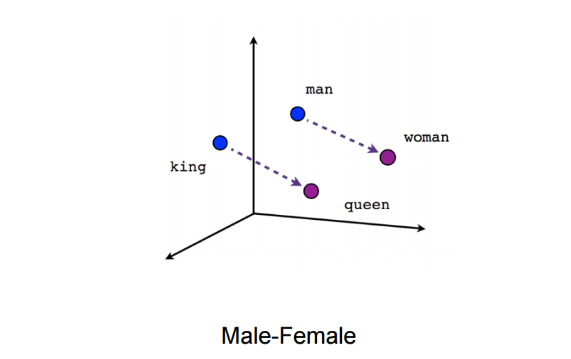

 King to queen is like man to woman.

The goal of doc2vec is to create a numeric representation of a document, regardless of its length. But unlike words, documents do not come in logical structures such as words, so the another method has to be found.

There are 2 methods for doc2vec : 


1.   **Distributed Bag of Words (DBOW)** : The paragraph vectors are obtained by training a neural network on the task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.
2.   **Distributed Memory (DM)** : DM acts as a memory that remembers what is missing from the current context — or as the topic of the paragraph. While the word vectors represent the concept of a word, the document vector intends to represent the concept of a document





Now we create a doc2vec model using distributed bag of words (DBOW), with 300-dimensional feature vectors.As for workers we use the system core threads to train the model.

In [ ]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 32842/32842 [00:00<00:00, 2725065.42it/s]


Now we must train the model for 30 epochs ( =  cycle through the full training dataset)

In [ ]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 32842/32842 [00:00<00:00, 2478174.54it/s]


CPU times: user 15min 52s, sys: 8.76 s, total: 16min 1s
Wall time: 8min 29s


Now we build the final vector for the classification

In [ ]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

Train the logistic regression classifier

In [ ]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
#val = vec_for_learning(model_dbow, val_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.5961007591442374
Testing F1 score: 0.5877933526887494


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
#get the probabilities for each category for every news
y_pred_prob = logreg.predict_proba(X_test)
y_pred_prob

array([[0.31495757, 0.68504243],
       [0.59052618, 0.40947382],
       [0.27332627, 0.72667373],
       ...,
       [0.45205008, 0.54794992],
       [0.3733367 , 0.6266633 ],
       [0.18195271, 0.81804729]])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

In [ ]:
def plot_binary_class_row_auc(y_true,
                              clf_names: list,
                              clfs_preds: list):
    """

    :param y_true: The true labels in one hot encoding
    :param clf_names: The names of the classifiers in order to plot
    :param clfs_preds: A list of numpy arrays, that contain predictions from various classifiers
    :return:
    """
    assert len(clf_names) == len(clfs_preds)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')

    for clf_name, preds in zip(clf_names, clfs_preds):
        fpr, tpr, thresholds = roc_curve(y_true,
                                         preds,pos_label='true')

        # AUC value can also be calculated like this.

        auc_score = auc(fpr, tpr)

        plt.plot(fpr,
                 tpr,
                 label='{} (area = {:.3f})'.format(clf_name, auc_score))

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

    # Zoom in view of the upper left corner.
    plt.figure(2)
    plt.xlim(0, 0.2)
    plt.ylim(0.7, 1)
    plt.plot([0, 1],
             [0, 1],
             'k--')

    for clf_name, preds in zip(clf_names, clfs_preds):
        fpr, tpr, thresholds = roc_curve(y_true,
                                         preds,pos_label='true')

        # AUC value can also be calculated like this.

        auc_score = auc(fpr, tpr)

        plt.plot(fpr, tpr,
                 label='{} (area = {:.3f})'.format(clf_name, auc_score))

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve (zoomed in at top left)')
    plt.legend(loc='best')
    plt.show()

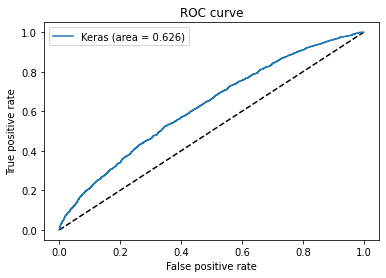

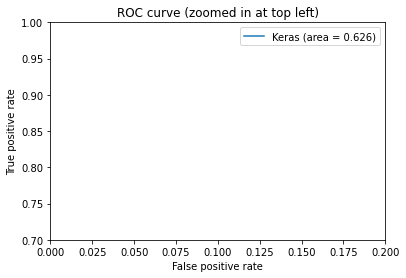

In [ ]:
plot_binary_class_row_auc(y_true=y_test,
                          clf_names=['Keras'],
                          clfs_preds=[y_pred_prob[:,1].ravel()])

In [ ]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred,labels =["fake", "true"])
pd.DataFrame(conf_mat, columns = ["fake", "true"],index = ["fake", "true"])

,fake,true
fake,1156,1461
true,880,2299


In [ ]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

        fake       0.57      0.44      0.50      2617
        true       0.61      0.72      0.66      3179

    accuracy                           0.60      5796
   macro avg       0.59      0.58      0.58      5796
weighted avg       0.59      0.60      0.59      5796



Before analyzing the classifiation report it is worth mentioning the definitions of the above metrics.

* **Precision**  : the number of correct positive results divided by the number of positive results predicted by the classifier.
* **Recall** : the number of correct positive results divided by the number of all samples that should have been identified as positive
* **F1 Score**: the Harmonic Mean between precision and recall. It shows how precise our classifier is (how many instances are classified correctly), as well as how robust it is (it does not miss a significant number of instances).
* **Support**: the number of news.

We will then try using the DM method for doc2vec and so we create a DM doc2vec model with a vector size with 300 words and iterating over the training corpus 30 times.


In [ ]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 32842/32842 [00:00<00:00, 1602947.95it/s]


In [ ]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 32842/32842 [00:00<00:00, 3027391.31it/s]


CPU times: user 27min 44s, sys: 24.7 s, total: 28min 9s
Wall time: 15min 15s


In [ ]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

KeyboardInterrupt: ignored

The accurancy and the F1 score are better using DM than DBOW. 


Let's evaluate this also : 

In [ ]:
#get the probabilities for each category for every news
y_pred_prob = logreg.predict_proba(X_test)
y_pred_prob

In [ ]:
plot_binary_class_row_auc(y_true=y_test,
                          clf_names=['Keras'],
                          clfs_preds=[y_pred_prob[:,1].ravel()])

In [ ]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred,labels =["fake", "true"])
pd.DataFrame(conf_mat, columns = ["fake", "true"],index = ["fake", "true"])

In [ ]:
print(classification_report(y_true=y_test, y_pred=y_pred))

To improve the scores we will create a new model that it will be a combination of DM and DBOW.


In [ ]:
!pip install testfixtures

In [ ]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

Build vectors for the classifier

In [ ]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

Train and predict using the new model.

In [ ]:
y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Finally evaluate the model.

In [ ]:
#get the probabilities for each category for every news
y_pred_prob = logreg.predict_proba(X_test)
y_pred_prob

In [ ]:
plot_binary_class_row_auc(y_true=y_test,
                          clf_names=['Keras'],
                          clfs_preds=[y_pred_prob[:,1].ravel()])

In [ ]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred,labels =["fake", "true"])
pd.DataFrame(conf_mat, columns = ["fake", "true"],index = ["fake", "true"])

In [ ]:
print(classification_report(y_true=y_test, y_pred=y_pred))

The scores are better than the DM and DBOW method.